## Ноутбук для обучения и валидации модели детекции с обновлением всех весов

Во многом этот ноутбук повторяет ноутбук с обучением префиксов, отличия лишь реализации обучения и гиперпараметрах

### Импортируем библотеки

In [154]:
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
import re
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, mean_squared_error, precision_score, accuracy_score, recall_score
from tqdm.auto import tqdm
from datasets import load_dataset
import matplotlib.pyplot as plt

### Фиксируем зависимости

In [155]:
device = 'cuda'
model_path = 'cointegrated/rubert-tiny'
dataset_path = 'shershen/ru_anglicism'
out_dir = 'weights'
linear_lr = 0
model_lr = 1e-5
epochs = 5
threshold = 0.8
batch_size = 8

### Функция для создания ner-маски

In [109]:
def create_mask(full_txts, phrases, max_length=512):
    if isinstance(full_txts, str):
        full_txts = [full_txts]
        phrases = [phrases]
    toks = tokenizer(full_txts, return_offsets_mapping=True,truncation=True,max_length=max_length,padding=True,return_tensors='pt')
    all_maps = []
    phrases = [x.split(', ') for x in phrases]
    for phrase,full_txt, off_map, att_mask in zip(phrases, full_txts,toks['offset_mapping'], toks['attention_mask']):
        local_maps = []
        for k, phr in enumerate(phrase):
            first_end = False
            ner_map = []
            start_point = full_txt.find(phr)
            end_point = start_point + len(phr)
            for s0,e0 in off_map.detach().cpu().numpy():
                if first_end:
                    ner_map.append(-100)
                elif s0!=e0 and s0>=start_point and e0<=end_point:
                    ner_map.append(1)
                elif s0!=e0 and e0>=start_point and e0<=end_point:
                    ner_map.append(1)
                elif s0==e0:
                    ner_map.append(-100)
                elif e0>len(full_txt):
                    ner_map.append(-100)
                    first_end = True
                else:
                    ner_map.append(0)
            if (len(phrase) > 1) and (k+1 == len(phrase)):
                ner_map = (np.array(ner_map) + np.array(local_maps[-1])).tolist()
                ner_map = [-100 if x == -200 else x for x in ner_map]
                ner_map = [1 if x == 2 else x for x in ner_map]
            if k+1 == len(phrase):
                all_maps.append(ner_map)
            else:
                local_maps.append(ner_map)
    return all_maps

### Скачиваем датасет и веса модели

In [5]:
df = load_dataset(dataset_path)
train_df = pd.DataFrame(df['train'])
test_df = pd.DataFrame(df['test'])

No config specified, defaulting to: ru_anglicism/default
Found cached dataset ru_anglicism (/home/jovyan/.cache/huggingface/datasets/shershen___ru_anglicism/default/0.1.0/cf5c584d109a310dfa58dcd48726f1f13d4327267043dfa9c2130e9b02217838)


  0%|          | 0/2 [00:00<?, ?it/s]

In [80]:
tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny')
model = AutoModel.from_pretrained('cointegrated/rubert-tiny').to(device)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [81]:
for i in model.parameters():
    i.requires_grad = True

### Функции для обучения и валидации

In [44]:
def ner_train(clsf_layer,df, model_lr=1e-3, linear_lr=1e-3, dx=16):
    loss_func = nn.CrossEntropyLoss(torch.tensor([1.,10.])).to(device)
    optimizer = torch.optim.AdamW([
        {'params': model.parameters(), 'lr': model_lr},
        {'params': [x for x in clsf_layer.parameters()], 'lr': linear_lr}
    ])
    losses = []
    print('Training...')
    for pos in tqdm(range(0,len(df),dx)):
        optimizer.zero_grad()
        txt = df['sentence'].values[pos:pos+dx].tolist()
        word = df['form'].values[pos:pos+dx].tolist()
        toks = tokenizer(txt, truncation=True, max_length=512,padding=True,return_tensors='pt').to(device)
        out = model(toks['input_ids'],attention_mask = toks['attention_mask'])['last_hidden_state']
        target = torch.tensor(create_mask(txt, word,max_length=512)).to(device)
        out = clsf_layer(out)
        loss = loss_func(out.view(-1,out.size(-1)),target.view(-1))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    return(losses) 

In [43]:
def ner_val(clsf_layer,df, threshold=0.8, dx=16):
    loss_func = nn.CrossEntropyLoss(torch.tensor([1.,10.])).to(device)
    losses = []
    precision_ner_score = []
    recall_ner_score = []
    f1s = []
    print('Validating...')
    for pos in tqdm(range(0,len(df),dx)):
        txt = df['sentence'].values[pos:pos+dx].tolist()
        word = df['form'].values[pos:pos+dx].tolist()
        toks = tokenizer(txt, truncation=True, max_length=512,padding=True,return_tensors='pt').to(device)
        out = model(toks['input_ids'],attention_mask = toks['attention_mask'])['last_hidden_state']
        target = torch.tensor(create_mask(txt, word,max_length=512)).to(device)
        out = clsf_layer(out)
        loss = loss_func(out.view(-1,out.size(-1)),target.view(-1))
        losses.append(loss.item())
        mask = F.softmax(out, dim=-1)[:,:,1]
        mask = torch.where(mask>=threshold, 1, 0)
        target[target==-100] = 0
        precision_ner = precision_score(target.cpu().numpy().tolist()[0], mask.cpu().numpy().tolist()[0], zero_division=0)
        recall_ner = recall_score(target.cpu().numpy().tolist()[0], mask.cpu().numpy().tolist()[0], zero_division=0)
        f1 = f1_score(target.cpu().numpy().tolist()[0], mask.cpu().numpy().tolist()[0], zero_division=0)
        precision_ner_score.append(precision_ner)
        recall_ner_score.append(recall_ner)
        f1s.append(f1)
    return(losses, precision_ner_score, recall_ner_score, f1s)

### Инициализируем линейный слой

In [82]:
linear = nn.Linear(312,2).to(device)
linear.requires_grad = True

### Класс ранней остановки

In [50]:
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss <= self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > self.min_validation_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### Обучение

In [83]:
train_losses = []
val_losses = []
early_stopper = EarlyStopper(patience=1)
for i in range(epochs):
    train_loss = ner_train(linear, train_df.sample(frac=1), model_lr, linear_lr, dx=batch_size)
    with torch.no_grad():
        val_loss, pr_ner_score, r_ner_score, f1s = ner_val(linear, test_df.sample(frac=1), threshold, dx=batch_size)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print('Epoch num: {} \n'.format(i+1),
          'Loss of train: {} \n'.format(np.mean(train_loss)), 
          'Loss of val: {} \n'.format(np.mean(val_loss)),
          'Precision_score_Ner:{} \n'.format(np.mean(pr_ner_score)),
          'Recall_score_Ner:{} \n'.format(np.mean(r_ner_score)),
          'F1_score_Ner:{} \n'.format(np.mean(f1s))
         )
    if early_stopper.early_stop(np.mean(val_loss)):             
        break

Training...


  0%|          | 0/125 [00:00<?, ?it/s]

Validating...


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch num: 1 
 Loss of train: 0.5832379195690155 
 Loss of val: 0.46348239345984027 
 Precision_score_Ner:0.40666278166278164 
 Recall_score_Ner:0.4201298701298702 
 F1_score_Ner:0.3531872168235805 

Training...


  0%|          | 0/125 [00:00<?, ?it/s]

Validating...


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch num: 2 
 Loss of train: 0.41912654900550844 
 Loss of val: 0.3741424652663144 
 Precision_score_Ner:0.355499803227076 
 Recall_score_Ner:0.4202020202020202 
 F1_score_Ner:0.3409349414697008 

Training...


  0%|          | 0/125 [00:00<?, ?it/s]

Validating...


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch num: 3 
 Loss of train: 0.34079151594638823 
 Loss of val: 0.3392075828530572 
 Precision_score_Ner:0.4418240850059032 
 Recall_score_Ner:0.5742424242424243 
 F1_score_Ner:0.3899591792639921 

Training...


  0%|          | 0/125 [00:00<?, ?it/s]

Validating...


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch num: 4 
 Loss of train: 0.2944689621925354 
 Loss of val: 0.3124868720769882 
 Precision_score_Ner:0.30902033459578215 
 Recall_score_Ner:0.5984848484848485 
 F1_score_Ner:0.34721399458241564 

Training...


  0%|          | 0/125 [00:00<?, ?it/s]

Validating...


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch num: 5 
 Loss of train: 0.2585085904598236 
 Loss of val: 0.30344480547037994 
 Precision_score_Ner:0.4857575757575758 
 Recall_score_Ner:0.7034632034632035 
 F1_score_Ner:0.47682964892996244 



### Рисунок лосса

In [84]:
def draw_result(lst_iter, train_loss, val_loss, title):
    plt.plot(train_loss, '-b', label='train loss')
    plt.plot(val_loss, '-r', label='val loss')

    plt.xlabel('n epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper left')
    plt.title(title)

    plt.show()

In [85]:
draw_train = [np.mean(x) for x in train_losses]
draw_test = [np.mean(x) for x in val_losses]

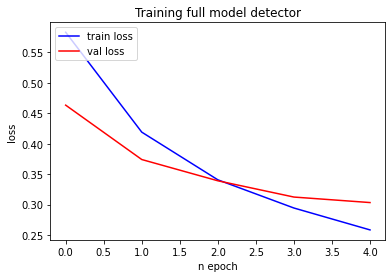

In [86]:
draw_result(epochs, draw_train, draw_test, 'Training full model detector')

### Посмотрим на одно предсказание

In [115]:
pos = 10
text = test_df['sentence'].values[pos]
phr = test_df['form'].values[pos]
print('Текст: \n' + text)
print('Англицизм: \n' + phr)
toks = tokenizer(text, 
                 padding=True,
                 max_length = 512,
                 truncation=True,
                 return_tensors='pt').to(device)
inp_ids = toks['input_ids']
att_mask = toks['attention_mask']

Текст: 
Игорь не знал, чем ответить на такой пространный спич и неопределенно похмыкал, делая вид, что понимает, о чем говорит Игорь Васильевич.
Англицизм: 
спич


In [116]:
with torch.no_grad():
    out = model(input_ids = inp_ids, attention_mask=att_mask)
    lin_out = linear(out['last_hidden_state'])
mask = F.softmax(lin_out,dim=-1)[:,:,1]
mask = torch.where(mask>=0.9, 1, 0)
print('Предсказание модели: \n' + tokenizer.decode((inp_ids*mask)[0], skip_special_tokens=True).strip())

Предсказание модели: 
спич


### Функция получения предсказаний, используем батч 1 для нормального вычисления метрик

In [133]:
def get_preds(clsf_layer, model, df, threshold=0.8, dx=1):
    f1_scores = []
    precision_scores = []
    recall_scores = []
    preds = []
    for pos in tqdm(range(0,len(df),dx)):
        txt = df['sentence'].values[pos:pos+dx].tolist()
        word = df['form'].values[pos:pos+dx].tolist()
        toks = tokenizer(txt, truncation=True, max_length=512,padding=True,return_tensors='pt').to(device)
        out = model(input_ids=toks['input_ids'],attention_mask = toks['attention_mask'])['last_hidden_state']
        target = torch.tensor(create_mask(txt, word, max_length=512)).to(device)
        out = clsf_layer(out)
        mask = F.softmax(out, dim=-1)[:,:,1]
        mask = torch.where(mask>=threshold, 1, 0)
        target[target==-100] = 0
        precision_ner = precision_score(target.cpu().numpy().tolist()[0], mask.cpu().numpy().tolist()[0], labels=[1], average='binary', zero_division=0)
        recall_ner = recall_score(target.cpu().numpy().tolist()[0], mask.cpu().numpy().tolist()[0], labels=[1], average='binary', zero_division=0)
        f1_ner = f1_score(target.cpu().numpy().tolist()[0], mask.cpu().numpy().tolist()[0], labels=[1],average='binary', zero_division=0)
        precision_scores.append(precision_ner)
        recall_scores.append(recall_ner)
        f1_scores.append(f1_ner)
        pr = [tokenizer.decode(x, skip_special_tokens=True).strip() for x in toks['input_ids']*mask]
        preds.extend(pr)
    return(f1_scores, precision_scores, recall_scores, preds)

In [143]:
f1_val, precision_val, recall_val, preds = get_preds(linear, model, test_df, threshold=threshold, dx=1)

  0%|          | 0/85 [00:00<?, ?it/s]

In [146]:
print('Final F1: \n{}'.format(np.mean(f1_val)))
print('Final precision: \n{}'.format(np.mean(precision_val)))
print('Final recall: \n{}'.format(np.mean(recall_val)))

Final F1: 
0.6001877113628359
Final precision: 
0.6356526806526807
Final recall: 
0.6441363211951447


In [149]:
pred_df = test_df.copy()
pred_df['preds'] = preds

In [150]:
pred_df.sample(10)

,word,form,sentence,paraphrase,preds
19,мэтчиться,мэтчиться,Ожидания перестают мэтчиться — вы расходитесь.,Ожидания перестают совпадать — вы расходитесь.,мэтчить
7,спич,спичем,"""Леди и гамильтоны"", торжественно сказал я сло...","""Леди и гамильтоны"", торжественно сказал я сло...",гамильыт гамиль
84,мэтч,мэтча,После мэтча вы договариваетесь встретиться и п...,После совпадения вы договариваетесь встретитьс...,мэтча
15,окей,Окей,"Окей, согласился Геннадий, не будем про отпеча...","Хорошо, согласился Геннадий, не будем про отпе...",
41,гандикап,гандикапы,Отыграть эти гандикапы практически невозможно.,Отыграть эту фору практически невозможно.,##ь гандикапы
63,клиффхэнгер,клиффхэнгером,"Так вот, первая глава “Мёртвых душ” кончается ...","Так вот, первая глава “Мёртвых душ” заканчивае...",клиффхэнгером
64,голкипер,голкипера,Для хоккейного голкипера необходимостью являет...,Для хоккейного вратаря необходимостью является...,хоккей голкипера щитки
81,"амбассадор, бренд","Амбассадор, бренд",Амбассадор помог популяризировать бренд.,Представитель помог популяризировать марку.,Амбассадорризировать бренд
40,гандикап,гандикап,К результатам участников старше 35 лет будет п...,К результатам участников старше 35 лет будет п...,гандикап
34,"репост, лайк","лайк, репост","Следует отметить, что лайк или репост какого-л...","Следует отметить, что одобрение или пересылка ...",лайк р


### Сохраняем веса

In [159]:
torch.save(model.state_dict(), os.path.join(out_dir, 'model_angls.pth'))
torch.save(linear.state_dict(), os.path.join(out_dir, 'lin_angls.pth'))

Полное обучение модели показало себя хуже, поскольку на небольшом количестве данных даже маленькая модель с низким learning rate начинает довольно быстро переобучаться, но это не означает, что сравнительно небольшой датасет не может использоваться при обучении, в ноутбуке с обучением префиксов, финальный f1 score получился 0.84, что является хорошим результатом.